# Implement the 3-qubit repetition code in Qiskit

References:
 - S. Girvin, [SciPost Phys.Lect.Notes 70 (2023) 1, arXiv:2111.08894](https://inspirehep.net/literature/1970411)

C.Andreopoulos \<c.andreopoulos@cern.ch\> - Dec 5th, 2023

In [1]:
import numpy as np
import re 

from qiskit import ClassicalRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit import Aer
from qiskit import transpile

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.visualization import plot_histogram

**Specify inputs**:

- **psi_state_vector**: This 2-D array describes the state vector of the unknown state $|\psi>$ we aim to protect from errors using the repetion code
- **circuit_option**: It selects between 2 different options for constructing the error correction circuit.
    - If circuit_option=1, the anchilla qubits are measured, and the logical (3-qubit) state is corrected by applying bit flip (X) gates conditional upon the anchilla qubit measurements.
    - If circuit_option=2, the anchilla qubits are not measured prior to correcting the logical state. Instead, we correct the error using a series of Toffoli (CCX) and bit-flip (X) gates as shown in Fig. 17 of arXiv:2111.08894.
- **p_err_bit_flip**: Probability for bit flip errors.
- **p_err_phase_flip**: Probability for phase flip errors.
- **err_qubit_list**: The list of qubits to apply errors, e.g. \[0,1,2\] for applying errors to all 3 qubits in a logical qubit, or \[0\] for applying the error only to the unknown state $|\psi>$
- **nshots**: Number of "experiments" simulated

In [2]:
#psi_state_vector = [1/np.sqrt(2),-1.j/np.sqrt(2)] # (|0>+|1>)/sqrt2
psi_state_vector = [1,0] # |0>
circuit_option   = 2
p_err_bit_flip   = 0.02
p_err_phase_flip = 0.0
err_qubit_list   = [0,1,2]
nshots           = 4096

**Define quantum and classical registers in the error correction circuit
and create a circuit with these registers.**

The circuit consists of 5 qubits:

| # | QISKit Id | Name      | Details   |    
|---|-----------|-----------|-----------|
|1|0|$\psi$|Qubit whose original unknown state $|\psi>$ we try to protect |
|2|1|$q_0$ |1$^{st}$ qubit entangled with $\psi$ to form a *logical qubit* (with basis states $|000>$ and $|111>$) |
|3|2|$q_1$ |2$^{nd}$ qubit entangled with $\psi$ to form a *logical qubit* |
|4|3|$c_0$ |1$^{st}$ anchilla qubit for mapping joint parity (error syndrome) $S_1$ |
|5|4|$c_1$ |2$^{nd}$ anchilla qubit for mapping joint parity (error syndrome) $S_2$ |

In [3]:
def instantiate_circuit(psi_state_vector):
    
    # The unknown state |psi> we need to protect
    psi = QuantumRegister(name='\psi', size=1) 

    # Anchilla qubits entangled with |\psi> to create the 
    # logical states |0>_L = |000> and |1>_L = |111>
    q = QuantumRegister(name='q', size=2) 

    # Anchilla qubits used for error syndrome measurements
    c = QuantumRegister(name='c', size=2) 

    # Error syndrome measurements
    error_syndrome = ClassicalRegister (name='syndrome', size=2)
    
    # Logical qubit measurements
    data = ClassicalRegister (name='l', size=3)

    # Instantiate a quantum circuit with the above registers
    qcircuit = QuantumCircuit(psi,q,c,error_syndrome,data)

    # Initialize qubits: 
    # Set the unknown state |psi> as specified by the user and everything else to |0>
    qcircuit.initialize(psi_state_vector, 0)
    qcircuit.initialize([1,0], 1)
    qcircuit.initialize([1,0], 2)
    qcircuit.initialize([1,0], 3)
    qcircuit.initialize([1,0], 4)

    # Entangle |psi> = a|0> + b|1> (qubit 1) with qubits 2,3 and 
    # create the state a|000> + b|111>
    qcircuit.cx(0,1)
    qcircuit.cx(0,2)

    qcircuit.barrier()

    return qcircuit

**Introduce errors** using various QISKit methods

The following is a **simple method for introducing bit flip and phase flip errors**.
With the inputs, ones specifies the the probability of each error, and the list of qubits where to apply errors (eg use \[0,1,2\] for all qubits in a logical qubit).

In [4]:
def bit_phase_flip_errors(qcircuit, p_err_bit_flip, p_err_phase_flip, qubit_list):
    p_no_err = 1 - p_err_bit_flip - p_err_phase_flip
    err = pauli_error(
        [('X', p_err_bit_flip), 
         ('Z', p_err_phase_flip), 
         ('I', p_no_err)])
    for qubit in qubit_list:
        qcircuit.append(err, [qubit])  
    qcircuit.barrier()

Below is a **more advanced method of introducing errors by creating and returning a *NoiseModel***. This model is then passed to the backend simulating the circuit.

Currently, only bit flip and phase flip errors are included with probabilities p_err_bit_flip and p_err_phase_flip.
The two errors are composed as follows:

| Error | Probablity | 
|-------|------------|
| Bit and phase flip | p_err_bit_flip     *    p_err_phase_flip   |
| Bit flip only      | p_err_bit_flip     * (1-p_err_phase_flip)  |
| Phase flip only    | (1-p_err_bit_flip) *    p_err_phase_flip   |
| No error           | (1-p_err_bit_flip) * (1-p_err_phase_flip)  |


In [5]:
def noise_model(p_err_bit_flip, p_err_phase_flip):
    
    # Build the bit and phase flip errors
    err_bit_flip   = pauli_error([('X', p_err_bit_flip),   ('I', 1 - p_err_bit_flip)])
    err_phase_flip = pauli_error([('Z', p_err_phase_flip), ('I', 1 - p_err_phase_flip)])    
    # Compose two errors:
    err_bitphase_flip = err_bit_flip.compose(err_phase_flip)
    print(err_bitphase_flip)
    # Build a noise model and add above errors
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(err_bitphase_flip, "measure")

    return nm

**Define the joint-parity operators (stabilizers)**

The two error syndromes are mapped to anchilla qubits 4, 5.

Each stabilizer $Z_i$ $Z_j$ is implemented by two CNOT gates on an anchilla qubit controlled by qubits $i$, $j$.

- $S_1$ = $Z_1 Z_2$, is defined by two CNOTs on anchilla qubit 4, controlled by qubits 1,2
- $S_2$ = $Z_3 Z_4$, is defined by two CNOTs on anchilla qubit 5, controlled by qubits 2,3

In [6]:
def add_stabilizer_operators(qcircuit):

    # Define S1 = Z1 Z2
    qcircuit.cx(0,3)
    qcircuit.cx(1,3)
    
    # Define S2 = Z2 Z3
    qcircuit.cx(1,4)
    qcircuit.cx(2,4)

    qcircuit.barrier()

**Apply error correction**

If **circuit_option=1**, the anchilla qubits 4,5, where the error syndromes were mapped to, are measured. Then, the logical qubit state is corrected by CX gates applied conditionally upon the outcome of these measurements.

If **circuit_option=2**, the logical qubit state is corrected by a series of X and CCX gates conditioned upon the anchilla qubits 4,5. No measurement of the anchilla qubits is required to correct the logical qubit. In any case, for completeness and to understand what the code tried to correct, the anchilla qubits 4,5 are also measured after the correction.

In both bases, the anchilla qubit 4 (5) measurement is stored at the classical register 1 (2).

*Note on implementing the error syndrome as two CX gates*

$S_1$|00> = +|00>, $S_1$ |01> = -|01>, $S_1$ |10> = -|10>, $S_1$ |11> = +|11> 
Therefore the truth table is:

| qubit 1  | qubit 2  |  S1 measurement  | 
|----------|----------|------------------|
|       0  |       0  | +1               |
|       0  |       1  | -1               |
|       1  |       0  | -1               |
|       1  |       1  | +1               |

On the other hand, for an anchilla qubit originally in state $|0>$,
the corresponding truth table for the two CX operations is:

| qubit 1  | qubit 2  | anchilla qubit state |
|----------|----------|----------------------|
|       0  |      0   |            0         |
|       0  |      1   |            1         |
|       1  |      0   |            1         |
|       1  |      1   |            0         |

Therefore:
- A value of 0 (1) in register 1 corresponds to $S_1$ measurement of +1 (-1)
- A value of 0 (1) in register 2 corresponds to $S_2$ measurement of +1 (-1)

The error syndrome measurement tells me what's wrong without collapsing the logical state. 
The table below is adapted from Tab. 3  in Girvin arXiv:2111.08894, taking into account the above.

<!-- 
  S1    S2    | classical  | how Qiskit    | detected | 
  measurement | register   | shows (*) the | error    | 
              | (<- qubit) | prev. column  |          |
              | 1(4) 2(5)  |               |          |
 -->
| $S_1$ | $S_2$ | bit (qubit): 1 (4) | bit (qubit): 2 (5) | Shown by QISKit as | Detected error |
|-------|-------|-----|-----|-------|---------|
|  +1   |  +1   |  0  |  0  | {00}  | $I$     |
|  -1   |  +1   |  1  |  0  | {01}  | $X_1$   | 
|  -1   |  -1   |  1  |  1  | {11}  | $X_2$   |     
|  +1   |  -1   |  0  |  1  | {10}  | $X_3$   | 


In [7]:
def add_error_correction_circuit(qcircuit, circuit_option):

    if(circuit_option==1):
        qcircuit.measure([3,4],[0,1]) 
        qcircuit.barrier()
        syndrome = qcircuit.clbits[0].register # deprecated: Use QuantumCircuit.find_bit instead
        qcircuit.x(0).c_if(syndrome,1)  # conditioned upon error_syndrome = {01}
        qcircuit.x(1).c_if(syndrome,3)  # conditioned upon error_syndrome = {11}
        qcircuit.x(2).c_if(syndrome,2)  # conditioned upon error_syndrome = {10}
        qcircuit.barrier()

    elif(circuit_option==2):
        qcircuit.ccx(4,3,1)
        qcircuit.x(4)
        qcircuit.ccx(4,3,0)
        qcircuit.x(3)
        qcircuit.x(4)
        qcircuit.ccx(4,3,2)
        qcircuit.barrier()
        # The above has corrected the errors that can be corrected by this code.
        # It is not required to measure the anchilla bits, but do it anyhow to have 
        # the same measurement outcome irrespective of the `circuit_option' setting.
        # However note that, along the way, qubit 4 was flipped. 
        # So flip it once more, to return to the original state describing the error syndrome.
        qcircuit.x(3)
        qcircuit.measure([3,4],[0,1]) 
        qcircuit.barrier()

**Measure the 3 qubits that make up the logical qubit**

In [8]:
def measure_logical_qubit(qcircuit):
    qcircuit.measure([0,1,2],[2,3,4]) 

**Run the quantum circuit**

In [9]:
def run_the_circuit(qcircuit,nshots=1024,nm=None):

    # Create a backend simulator
    # backend = BasicAer.get_backend("qasm_simulator")
    backend = Aer.get_backend("aer_simulator")
    if(nm != None):
        backend.set_options(noise_model=nm)

    # Transpile the quantum circuit
    # This generates low-level QASM instructions used by the backend
    qcircuit_compiled = transpile(qcircuit, backend)

    # Execute the circuit on the simulator
    # Use the specified number of iterations (shots)
    simulation_job = backend.run(qcircuit_compiled,shots=nshots)

    # Get the simulation results
    simulation_result = simulation_job.result()

    return qcircuit_compiled, simulation_result

## Test

Initialize the quantum circuit

In [10]:
qcircuit = instantiate_circuit(psi_state_vector)

**Introduce errors** (various methods supported)

Set $|\psi>$ to $|0>$ and run the following simple scenarios and check that the 3 qubit repetition code implemented here performs as expected:
 - Introduce a **bit flip error in a single qubit** by running bit_phase_flip_errors(qcircuit, p_err, 0, \[0\]): <br>
   The code should correct all errors.<br>
   Measurements counts should be {000 00} with probability = 1-p_err
   and {000 01} with probability = p_err
 - Introduce a **bit flip error on any of the 3 qubits** of the logical state by running bit_phase_flip_errors(qcircuit, p_err, 0, \[0,1,2\]): <br>
   The code should correct all cases with 1 error, but fail if $>$1 errors occur.<br>
   Measurements counts should be:
   - {000 00} with probability = 1-3*p_err
   - {000 01}, {000 10}, {000 11} with probability = p_err
   - failed (other) cases with probability = 3*p_err^2
     

In [11]:
# a simple method of introducing errors
bit_phase_flip_errors(qcircuit, p_err_bit_flip, p_err_phase_flip, err_qubit_list)

# a more advanced method of introducing errors
nm = None
# nm = noise_model(p_err_bit_flip, p_err_phase_flip)
# print(nm)

/usr/local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


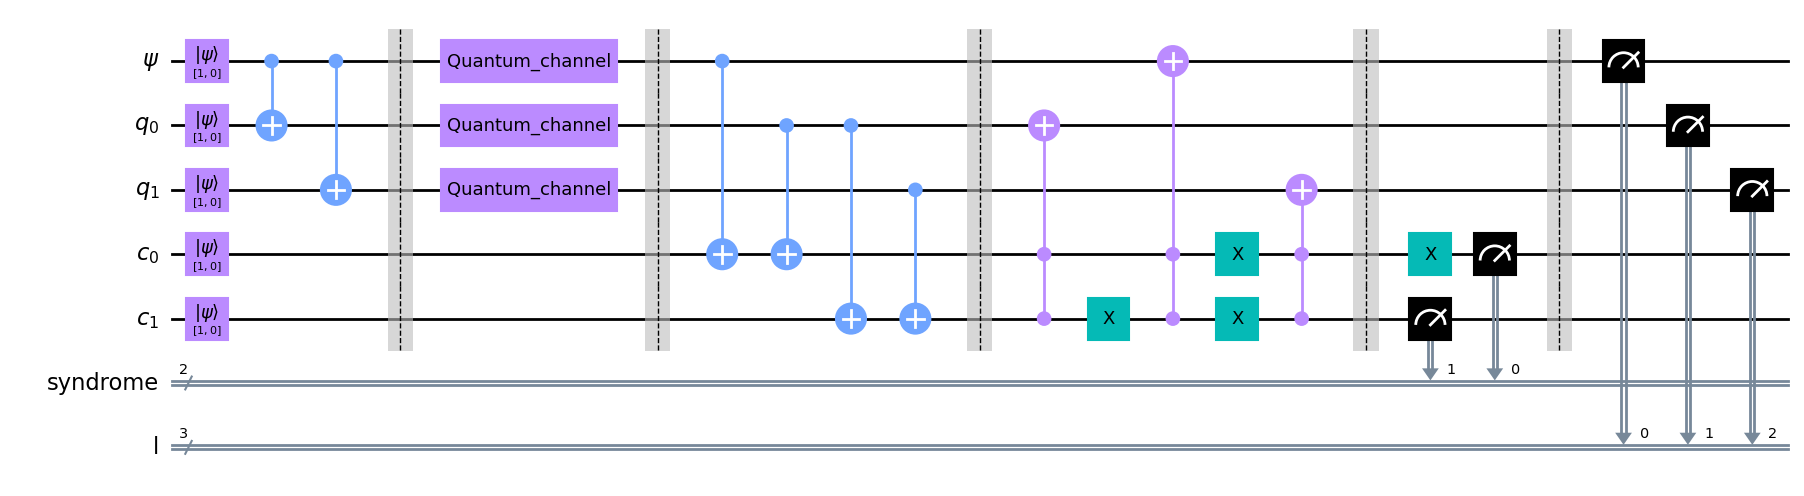

In [12]:
# add stabiliser, error correction & measure

add_stabilizer_operators     (qcircuit)
add_error_correction_circuit (qcircuit,circuit_option)
measure_logical_qubit        (qcircuit)

qcircuit.draw("mpl")

In [13]:
# Simulate
qcircuit_compiled, simulation_result = run_the_circuit(qcircuit,nshots,nm)

**Get and print/plot the measurement counts**

The measurement counts are reported as: {xxx xx}

- The first 3 counts are the measurements of {q1 q0 \psi}
  This should be either {000} or {111}, having corrected an error within the logical qubit
- The last 2 counts are the error syndrome (see Table in comments above).
  For example:
    - If no error was introduced, we should see only {00} counts
    - If a bit flip was introduced in qubit 1, should see only {01} counts

In [14]:
measurement_counts = simulation_result.get_counts(qcircuit_compiled)
print(measurement_counts)

{'111 10': 2, '111 11': 3, '000 01': 87, '000 11': 81, '111 01': 3, '000 10': 82, '000 00': 3838}


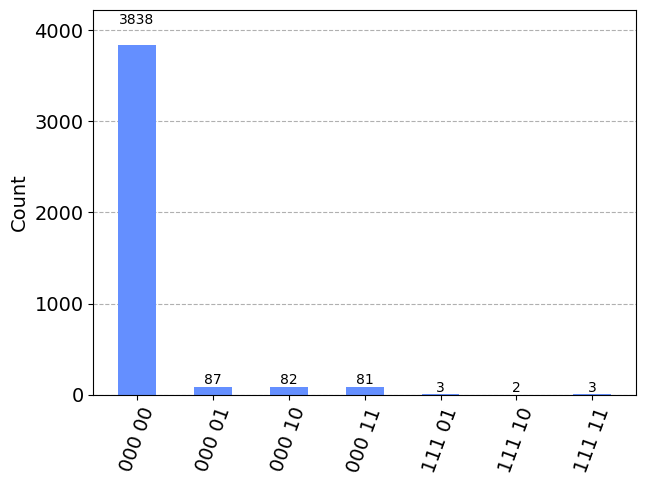

In [15]:
plot_histogram(measurement_counts)

Count the fraction of shots resulting in a logical state that does not match the input one.
The code below works only if $|psi>$ is set to $|0>$ or $|1>$.

In [16]:
pattern = None

if   (np.array_equal(psi_state_vector,[1,0])): pattern = '000 \w*'
elif (np.array_equal(psi_state_vector,[0,1])): pattern = '111 \w*'

if (pattern != None):
    selected_counts = [measurement_counts[key] for key in measurement_counts if re.match(pattern,key)!=None]
    nshots_correct = np.sum(selected_counts)
    frac_correct = nshots_correct/nshots
    print(nshots_correct, " (", 100*frac_correct, "%) of shots resulted in a correct logical state")

4088  ( 99.8046875 %) of shots resulted in a correct logical state


In [17]:
import qiskit.tools.jupyter
%qiskit_version_table